<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/machine-learning-bookcamp/7-neural-network/01_fashion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Fashion classification project



Imagine that we work at an online fashion marketplace. Our users upload thousands
of images every day to sell their clothes. We want to help our users create listings faster
by automatically recommending the right category for their clothes.

To solve our problem, we need a different type of model: a convolutional neural
network, a special model used for images.

The plan for our project is:

* First, we download the dataset and use a pretrained model to classify images.
* Then, we talk about neural networks, and see how they work internally.
* After that, we adjust the pretrained neural network for solving our tasks.
* Finally, we expand our dataset by generating many more images from the images we have.

##Setup

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

##Dataset

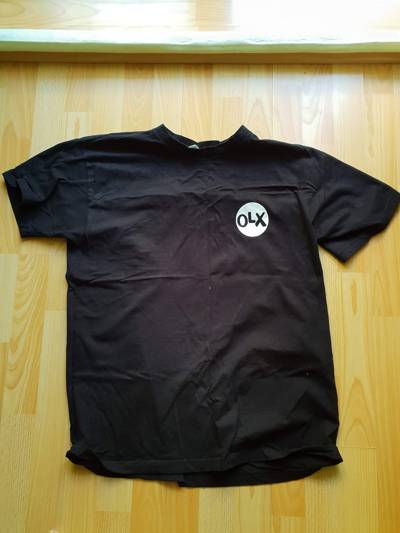

In [3]:
# let’s load a T-shirt image
ROOT_PATH = "clothing-dataset-small"
fullname= ROOT_PATH + "/train/t-shirt/5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg"
load_img(fullname)

In [4]:
# let's resize the image
img = load_img(fullname, target_size=(299, 299))

In [5]:
x = np.array(img)
x.shape

(299, 299, 3)

##Pretrained model

* Imagenet dataset: https://www.image-net.org/
* Pre-trained models: https://keras.io/api/applications/

In [ ]:
model = Xception(weights="imagenet", input_shape=(299, 299, 3))

In [7]:
# convert sample input into batch sample
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [8]:
# preprocess the sample
X = preprocess_input(X)

In [9]:
pred = model.predict(X)
pred.shape

1/1 [==============================] - 9s 9s/step


(1, 1000)

In [10]:
# decode the prediction
decode_predictions(pred)

35363/35363 [==============================] - 0s 0us/step


[[('n03595614', 'jersey', 0.6792447),
  ('n02916936', 'bulletproof_vest', 0.039600365),
  ('n04370456', 'sweatshirt', 0.03529961),
  ('n03710637', 'maillot', 0.010884137),
  ('n04525038', 'velvet', 0.0018057592)]]

##Transfer learning

* Reading data with `ImageDataGenerator`
* Train `Xception` on smaller images `(150x150)`

In [11]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_ds = train_gen.flow_from_directory("clothing-dataset-small/train",
                              target_size=(150, 150),
                              batch_size=32)

Found 3068 images belonging to 10 classes.


In [12]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [13]:
!ls -l clothing-dataset-small/train

total 256
drwxr-xr-x 2 root root 20480 May 18 11:28 dress
drwxr-xr-x 2 root root 12288 May 18 11:28 hat
drwxr-xr-x 2 root root 40960 May 18 11:28 longsleeve
drwxr-xr-x 2 root root 20480 May 18 11:28 outwear
drwxr-xr-x 2 root root 36864 May 18 11:28 pants
drwxr-xr-x 2 root root 20480 May 18 11:28 shirt
drwxr-xr-x 2 root root 20480 May 18 11:28 shoes
drwxr-xr-x 2 root root 20480 May 18 11:28 shorts
drwxr-xr-x 2 root root 12288 May 18 11:28 skirt
drwxr-xr-x 2 root root 57344 May 18 11:28 t-shirt


In [14]:
X, y = next(train_ds)
X.shape

(32, 150, 150, 3)

In [15]:
y[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [16]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory("clothing-dataset-small/validation",
                              target_size=(150, 150),
                              batch_size=32,
                              shuffle=False)

Found 341 images belonging to 10 classes.


In [ ]:
# let's load pretrained model
base_model = Xception(weights="imagenet",
                      include_top=False,
                      input_shape=(150, 150, 3))
base_model.trainable = False

In [18]:
# let's get vectors from base model for top dense layer input
inputs = keras.Input(shape=(150, 150, 3))

base_output = base_model(inputs)

model = keras.Model(inputs, base_output)

In [19]:
preds = model.predict(X)

1/1 [==============================] - 2s 2s/step


In [20]:
preds.shape

(32, 5, 5, 2048)

In [21]:
# let's get vectors from base model for top dense layer input
inputs = keras.Input(shape=(150, 150, 3))

base_output = base_model(inputs)

# convert 3D base output into 1D vectors
pooling_layer = keras.layers.GlobalAveragePooling2D()
vectors = pooling_layer(base_output)
# vectors = keras.layers.GlobalAveragePooling2D()(base_output)

outputs = vectors

model = keras.Model(inputs, outputs)

In [22]:
preds = model.predict(X)

1/1 [==============================] - 1s 669ms/step


In [23]:
preds.shape

(32, 2048)

In [24]:
# let's create new top dense layers and add on top of base model
inputs = keras.Input(shape=(150, 150, 3))

base_output = base_model(inputs, training=False)

# convert 3D base output into 1D vectors
vectors = keras.layers.GlobalAveragePooling2D()(base_output)

outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

In [25]:
preds = model.predict(X)

1/1 [==============================] - 1s 1s/step


In [26]:
preds.shape

(32, 10)

In [27]:
preds[0]

array([ 0.17885363, -0.08843642, -1.9545447 , -0.39278063,  0.12376457,
        1.2373147 ,  0.8375246 , -0.83810574,  0.20232515, -1.5178653 ],
      dtype=float32)

In [28]:
learning_rate=0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

In [29]:
model.compile(optimizer=optimizer,
              loss=loss, 
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

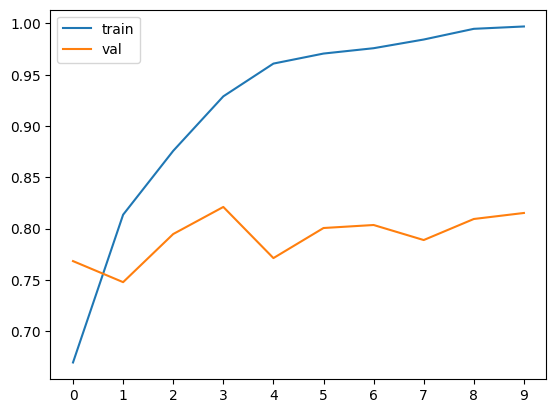

In [31]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.xticks(np.arange(10))
plt.legend()
plt.show()

##Adjusting the learning rate

In [32]:
def make_model(learning_rate=0.01):
  # let's load pretrained model
  base_model = Xception(weights="imagenet",
                        include_top=False,
                        input_shape=(150, 150, 3))
  base_model.trainable = False

  # let's create new top dense layers and add on top of base model
  inputs = keras.Input(shape=(150, 150, 3))
  base_output = base_model(inputs, training=False)
  # convert 3D base output into 1D vectors
  vectors = keras.layers.GlobalAveragePooling2D()(base_output)
  outputs = keras.layers.Dense(10)(vectors)
  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  model.compile(optimizer=optimizer,
              loss=loss, 
              metrics=["accuracy"]
              )
  return model

In [ ]:
scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
  print(lr)
  model = make_model(learning_rate=lr)
  history = model.fit(train_ds, epochs=10, validation_data=val_ds)
  scores[lr] = history.history
  print()
  print()

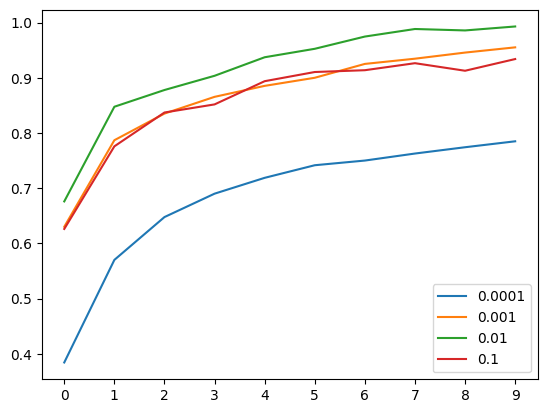

In [34]:
for lr, hist in scores.items():
  plt.plot(hist["accuracy"], label=lr)

plt.xticks(np.arange(10))
plt.legend()
plt.show()

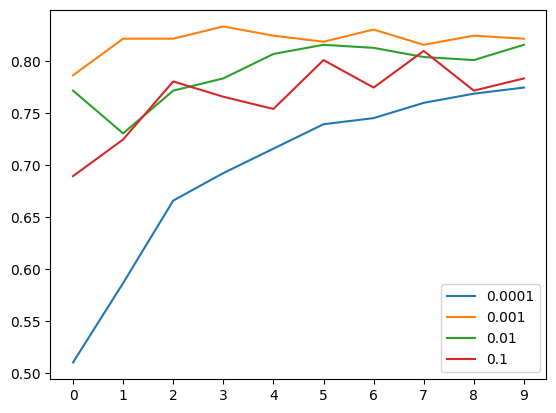

In [35]:
for lr, hist in scores.items():
  plt.plot(hist["val_accuracy"], label=lr)

plt.xticks(np.arange(10))
plt.legend()
plt.show()

In [36]:
del scores[0.1]
del scores[0.0001]

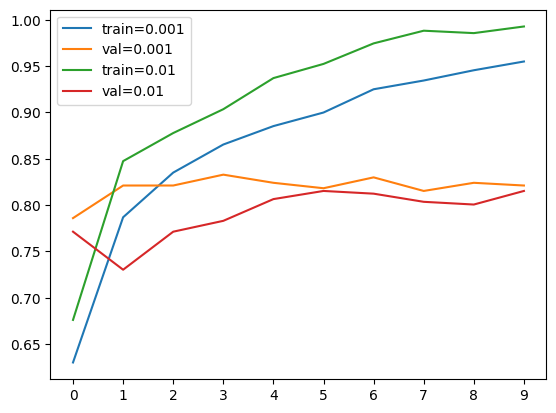

In [37]:
for lr, hist in scores.items():
  plt.plot(hist["accuracy"], label=("train=%s" % lr))
  plt.plot(hist["val_accuracy"], label=("val=%s" % lr))

plt.xticks(np.arange(10))
plt.legend()
plt.show()

In [38]:
# best learning_rate param
learning_rate = 0.001

##Model checkpointing

In [ ]:
callbacks = [
  keras.callbacks.ModelCheckpoint("xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
                                  monitor="val_accuracy",
                                  save_best_only=True,
                                  mode="max")
]

model = make_model(learning_rate=0.001)

history_0_001 = model.fit(train_ds,
                          epochs=10,
                          validation_data=val_ds,
                          callbacks=callbacks)

##Adding more layers

In [40]:
def make_model(learning_rate=0.01, inner_size=100):
  # let's load pretrained model
  base_model = Xception(weights="imagenet",
                        include_top=False,
                        input_shape=(150, 150, 3))
  base_model.trainable = False

  # let's create new top dense layers and add on top of base model
  inputs = keras.Input(shape=(150, 150, 3))
  base_output = base_model(inputs, training=False)
  # convert 3D base output into 1D vectors
  vectors = keras.layers.GlobalAveragePooling2D()(base_output)
  # Let's add one more layer
  inner_layer = keras.layers.Dense(inner_size, activation="relu")(vectors)
  outputs = keras.layers.Dense(10)(inner_layer)
  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  model.compile(optimizer=optimizer,
              loss=loss, 
              metrics=["accuracy"]
              )
  return model

In [ ]:
# best learning_rate param
learning_rate = 0.001

scores = {}
for layer in [10, 100, 1000]:
  print(layer)
  model = make_model(learning_rate=learning_rate, inner_size=layer)
  history = model.fit(train_ds, epochs=10, validation_data=val_ds)
  scores[layer] = history.history
  print()
  print()

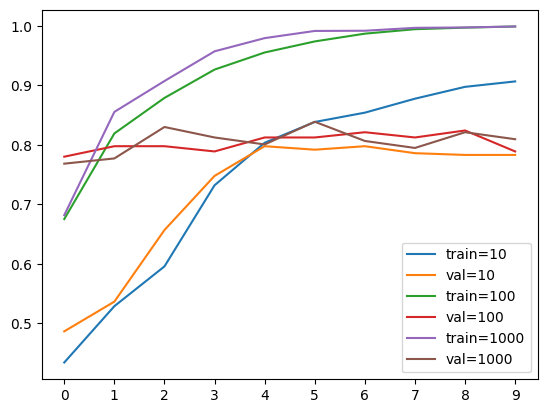

In [42]:
for layer, hist in scores.items():
  plt.plot(hist["accuracy"], label=("train=%s" % layer))
  plt.plot(hist["val_accuracy"], label=("val=%s" % layer))

plt.xticks(np.arange(10))
plt.legend()
plt.show()

In [43]:
# best optimal layer
inner_size = 100

##Regularization and dropout

In [44]:
def make_model(learning_rate=0.01, inner_size=100, dropout_rate=0.5):
  # let's load pretrained model
  base_model = Xception(weights="imagenet",
                        include_top=False,
                        input_shape=(150, 150, 3))
  base_model.trainable = False

  # let's create new top dense layers and add on top of base model
  inputs = keras.Input(shape=(150, 150, 3))
  base_output = base_model(inputs, training=False)
  # convert 3D base output into 1D vectors
  vectors = keras.layers.GlobalAveragePooling2D()(base_output)
  # Let's add one more layer
  inner_layer = keras.layers.Dense(inner_size, activation="relu")(vectors)
  # Let's add dropout layer
  dropout_layer = keras.layers.Dropout(dropout_rate)(inner_layer)
  outputs = keras.layers.Dense(10)(dropout_layer)
  
  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  model.compile(optimizer=optimizer,
              loss=loss, 
              metrics=["accuracy"]
              )
  return model

In [ ]:
# best learning_rate param
learning_rate = 0.001
# best optimal layer
inner_size = 100

scores = {}
for droprate in [0.0, 0.2, 0.5, 0.8]:
  print(droprate)
  model = make_model(learning_rate=learning_rate, inner_size=inner_size, dropout_rate=droprate)
  history = model.fit(train_ds, epochs=30, validation_data=val_ds)
  scores[droprate] = history.history
  print()
  print()

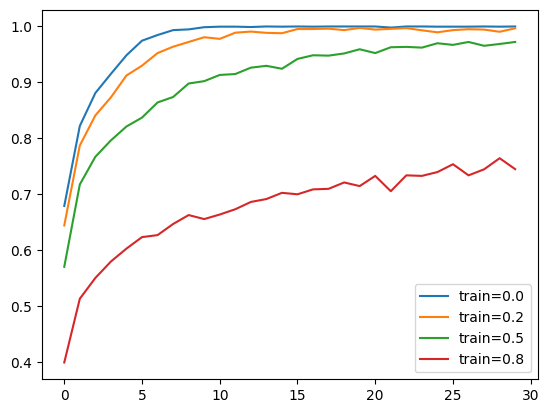

In [52]:
for droprate, hist in scores.items():
  plt.plot(hist["accuracy"], label=("train=%s" % droprate))

plt.legend()
plt.show()

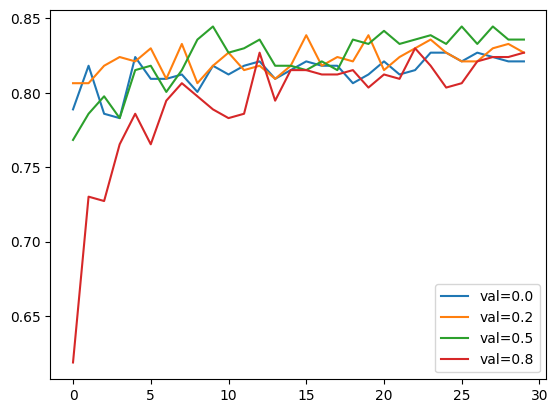

In [53]:
for droprate, hist in scores.items():
  plt.plot(hist["val_accuracy"], label=("val=%s" % droprate))

plt.legend()
plt.show()

In [ ]:
# best droprate
droprate = 0.5

##Data augmentation